In [1]:
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(),"..")))

from data.get_data import get_mnist_data
#import Data_acq as data
from models_definitions import encoder
from models_definitions import decoder
from models_definitions import cvae
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.callbacks import EarlyStopping


dataset="mnist"
data = get_mnist_data(dataset=dataset)

x_train = data["x_train"]
x_val = data["x_val"]
y_train = data["y_train"]
y_val = data["y_val"]

original_dim = 28*28
beta = 1.0

train_dataset = tf.data.Dataset.from_tensor_slices(((x_train, y_train), x_train))
train_dataset = train_dataset.batch(128)

early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=3,          
    restore_best_weights=True  
)

val_dataset = tf.data.Dataset.from_tensor_slices(((x_val, y_val), x_val))
val_dataset = val_dataset.batch(128)


intermediate_dim=[1024]
latent_dim=[256]
  
for i in range(len(intermediate_dim)):
    en = encoder.build_enconder(intermediate_dim=intermediate_dim[i],latent_dim=latent_dim[i])
    de = decoder.build_decoder(intermediate_dim=intermediate_dim[i],latent_dim=latent_dim[i])
        
    cvae = cvae.CVAE(encoder=en, decoder=de, original_dim=original_dim, beta=beta)
    cvae.compile(optimizer=tf.keras.optimizers.Adam())

    cvae.fit(train_dataset,
            epochs=100,
            batch_size=128,
            validation_data=val_dataset,
            callbacks=[early_stopping]
            )

    en.save(f"en_int_{intermediate_dim[i]}_lat_{latent_dim[i]}_{dataset}.keras")
    de.save(f"de_int_{intermediate_dim[i]}_lat_{latent_dim[i]}_{dataset}.keras")




2025-08-19 18:34:11.366191: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-19 18:34:11.369481: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-19 18:34:11.379288: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755639251.395717  180626 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755639251.400449  180626 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1755639251.413449  180626 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

Usando mnist como dataset


E0000 00:00:1755639255.935235  180626 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1755639255.936136  180626 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch 1/100
430/430 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - kl_loss: 3.5219 - loss: 46.0803 - reconstruction_loss: 42.5630 - val_kl_loss: 4.8961 - val_loss: 37.8198 - val_reconstruction_loss: 32.9581
Epoch 2/100
430/430 ━━━━━━━━━━━━━━━━━━━━ 18s 41ms/step - kl_loss: 5.4571 - loss: 36.8028 - reconstruction_loss: 31.3443 - val_kl_loss: 5.6033 - val_loss: 34.8659 - val_reconstruction_loss: 29.3294
Epoch 3/100
430/430 ━━━━━━━━━━━━━━━━━━━━ 19s 44ms/step - kl_loss: 6.0589 - loss: 34.7572 - reconstruction_loss: 28.6968 - val_kl_loss: 6.2236 - val_loss: 33.0919 - val_reconstruction_loss: 26.9364
Epoch 4/100
430/430 ━━━━━━━━━━━━━━━━━━━━ 19s 44ms/step - kl_loss: 6.3142 - loss: 33.3158 - reconstruction_loss: 27.0008 - val_kl_loss: 6.1623 - val_loss: 31.9589 - val_reconstruction_loss: 25.8591
Epoch 5/100
430/430 ━━━━━━━━━━━━━━━━━━━━ 20s 47ms/step - kl_loss: 6.5002 - loss: 32.4791 - reconstruction_loss: 25.9774 - val_kl_loss: 6.4779 - val_loss: 31.4391 - val_reconstruction_loss: 25.0031
Epoch 6/100
430

CROP-1 consta de 2 modelos entrenados por separados con imagnes limpias que interactuan entre sí con el fin de separa mezclas de imagenes. Por un lado un autoeoncder variacional condicional (CVAE) cuyo objetivo es reconstruir una imagen a partir de una imagen de input y dos condiciones (en general son iguales) y una red convolucional capaz de aprender representaciones para clasificar las imagenes. 


## Auto Encoder

### Encoder
Los autoencoder son redes neuronales de tipo Enconder-Decoder con el fin de generar output igual al input. 
Los Encoders comprimen las imagenes en varios pasos hasta alcanzar una representación en el espacion latente. 
En este caso, la imagen input se apalana y se concatena con las condición del encoder (input_concat) que se pasa a una capa densa de dimensión "intermediate_dim" (por defecto 128) y luego se pasa por otra capa densa cuya salida es de dimensión laten_dim (por defecto 2).

### Decoder
Los Decoders generan un output a partir del espacio latente usando "descomprimendo" el output en dimensiones cada vez mayores hasta alcanzar un resultado de una dimensión igual a la del input. En este caso, la entrada del decoder es el espacio latente, generado por el encoder, concatenado con la condición del decoder. Este decoder_input, es usado en una capa densa cuya salida es un vector de dimesión "intermediate_dim" (igual que en el encoder) y finalmente la salida del decoder es una vector de dimensión igual a la de entrada (28*28).

## Auto Encoder Variacional
A diferencia el los autoencoders, los autoencoder variacionales tienen como obejtivo aprender representaciones y generar pequeñas variaciones las entradas. Esto se logra usando una estructura clásica de encoder-decoder pero remplazando el espacio latente por una representación probabilistica. 
De esa manera. El enconder logra mapear el espacio de los inputs a distribuciones en el espacio latente y el decoder mapea esas distribuciones nuevamente al espacio de entrada. 
Para entrenar estos modelos, es necesario introducir dos metricas de error. Por una lado tenemos el error de reconstrucción que mide la calidad de los outputs generados contra los inputs. Por otro lado tenemos la divergencia Kullback–Leibler que mide la diferencia entre la distribución de la represensión de los datos en el espacio latente y una gaussiana. La función de coste es la suma de estos dos errores. Adicionlamente, el coste KL se multiplica por un factor Beta(en nuestro caso 1).
En estas arquitecturas para poder seguir usando backpropagation como método de ajuste de pesos, es necesario hacer un muestro del espacio latente, por lo que ademas del espacio latente z tenemos z_mu y z_var. //entender para que se usan


# Auto Encoder Variacional Condicional (CVAE)
Un auto Encoder Variacional Condicional es VAE al que se le agrega un vector de condiciones para controlar el output generado, un promt. El espacio latente ahora no necesita aprender clases, parende estrucutras como formas ne lugar de clases. Cualquier punto del espacio latente puede ser usando para generar cualquier imagen dada la condción del decoder.


## Resumen de parametros destacados:
- Dimensión del espacio latente: 2 (por defecto, se puede elegir) 
- Dimensión intermedia: 128 (por defecto)
- Beta 1
- Dimensión de entrada, 28*28
- 10 clases en el data set --> Vector de condiciones de 10.


## Predictor
El predictor o clasificador es una red neuronal convolucional con el fin de aprender representaciones de las distitnas clases.
## Parametros de interes:
Función de activacion softmax para que el output sea una probabilidad
batchnormalization (buscar)
dropout de 0.5 (buscar)



### Modelo CROP-1:

El modelo funciona con la interacción de los otros modelos explicados anteriormente con el fin de, dada una imagen mezcla, obtener las dos imagenes limpias.


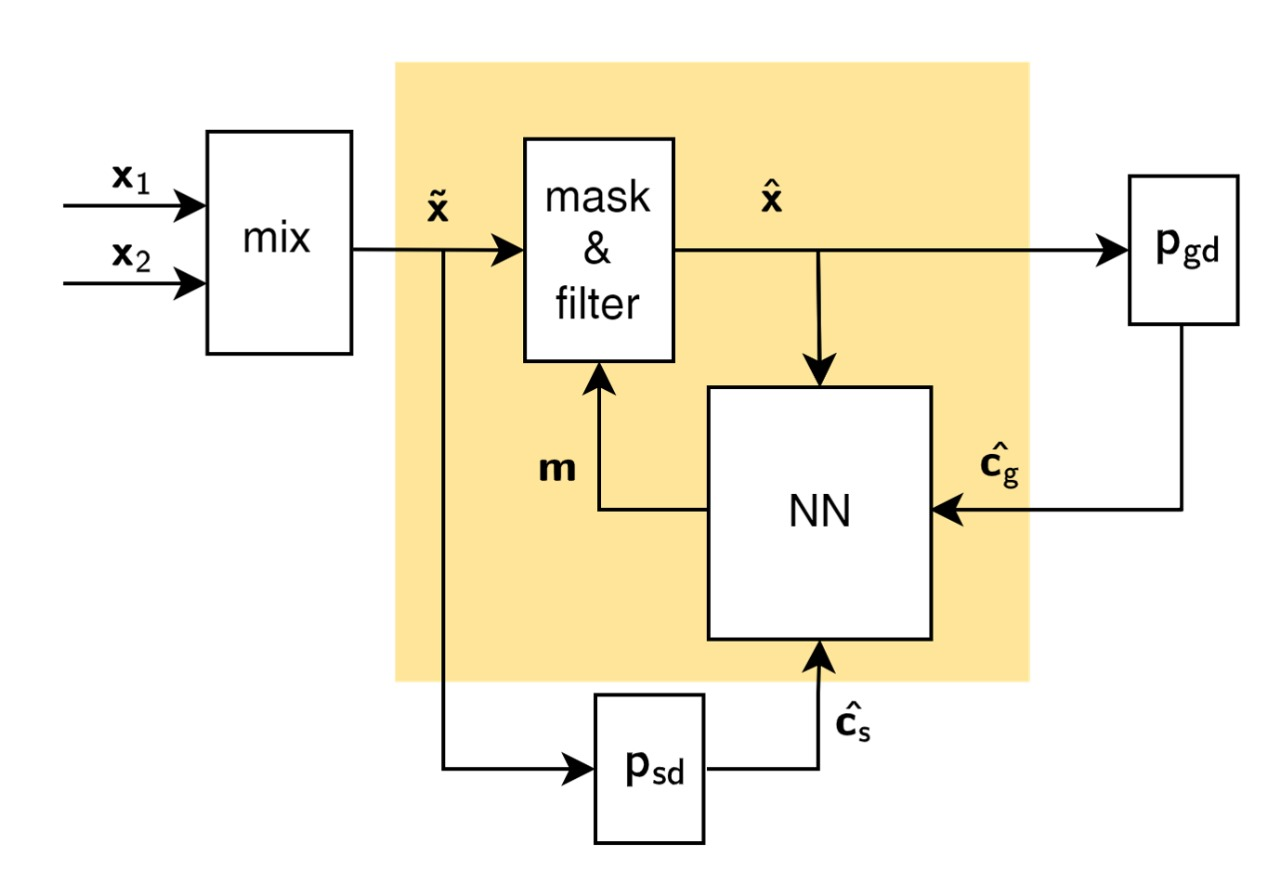

En un primer instante, la imagen mezcla $ x^~ $ es alimentada a Psd (modelo predictor) para geenrar la condición que es input del CVAE Cs. a su vez la imagen muestra se procesa con mascaras y/o filtros (en la primera pasada no hay ni mascaras ni filtros, la imagen pasa limpia) x ^. Esta imagen, junto con la condición alimentan a la CVAE el cual genera una imagen del dígito predicho (el indicado por Cs) la cual se usa como mascara de para la próxima iteración. 
Durante las siguientes iteraciones la estimación del digito más probable queda a cargo del bloque Pgd qeu genera la condición Cg la cual alimenta el CVAE. Mientras tanto la salida m de la iteración i-1 se usa como máscara para la salida de la iteración i para genera x^, lo cual vuelve a arrancar el ciclo. 



In [ ]:
#TODO: modelo con ambos data sets? no suena buena idea 
